# BoomBikes
### Problem Statement: 
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19, for that they took the help from a service provider firm. Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. Specifically, BoomBikes want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands

### Steps to solve the problem:
 1. Reading & understanding the data (EDA)
 2. Preparing the data for modeling
 3. Model Building
 4. Making predictions and Evaluation on the test set
 5. Interpreting the model

In [256]:
# Importing all the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

### Step 1 : Reading & understanding the data (EDA)

In [257]:
bikes = pd.read_csv('day.csv')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [258]:
bikes.info()
# Data looks complete, means there are no missing values in any given column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [259]:
# dropping the column named 'instant' as it's just the numeric id for the record, and doesn't provide any
# meaningful information. And also dropping the col 'dteday' as we are looking for trends in weekdays, months, seasons etc.
bikes = bikes.drop('instant', axis=1)
bikes = bikes.drop('dteday', axis=1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [260]:
# Most of the variables are categorical, but are present as numeric, in order to do the EDA,
# it would be helpful to visualize them if we map the numeric values to meaningful names,
# like converting the Weekdays to Sunday, Monday etc. Seasons to Spring, Summer etc.

def mapToName(colName, hm):
    bikes[colName] = bikes[colName].map(hm)

mapToName('season', {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
mapToName('mnth', {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
mapToName('weathersit', {1: 'Clear',2:'Mist + Cloudy',3:'Light Rain',4:'Heavy rain'})
mapToName('weekday', {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


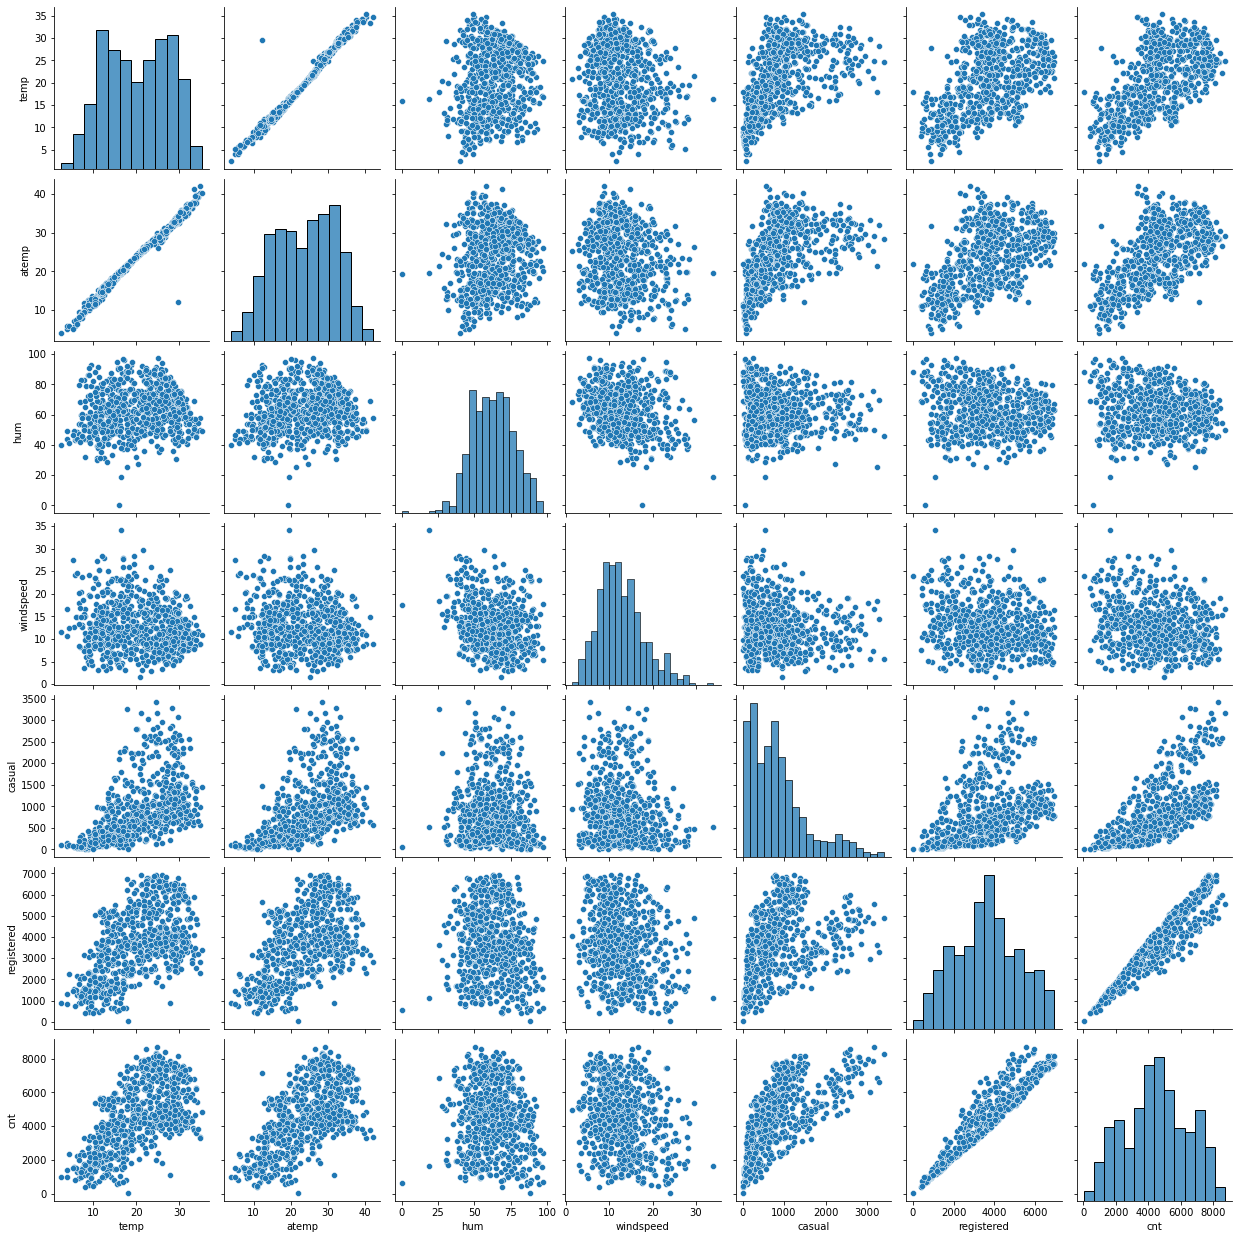

In [261]:
# Pairplot for numeric variables
sns.pairplot(bikes, vars=["temp", 'atemp', "hum", 'windspeed', 'casual', 'registered','cnt'])
plt.show()

# learnings from pairplot:
#   - seems like there is a strong positive correlation between temp and atemp, maybe we would remove one of them while removing multi-collinearity
#   - there is small positive correlation between cnt and temp/atemp, casual and registered


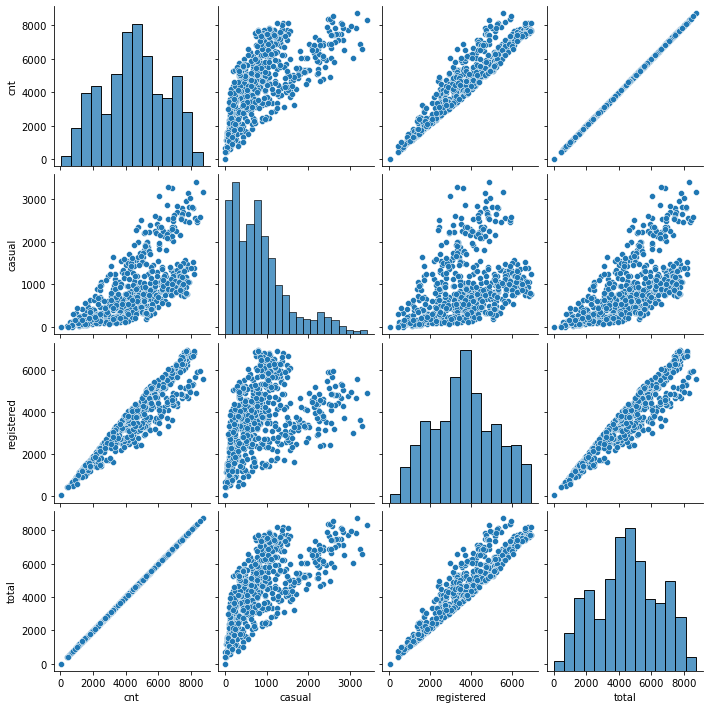

In [262]:
# Let's look at the relationship between cnt, casual and registered
tmp_df = bikes[['cnt', 'casual', 'registered']]
tmp_df['total'] = bikes['casual'] + bikes['registered']
sns.pairplot(tmp_df)
plt.show()

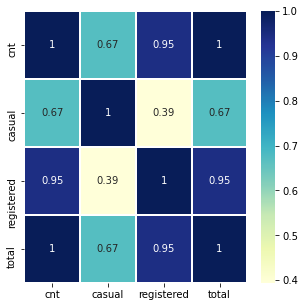

In [263]:
plt.figure(figsize = (5,5))
sns.heatmap(tmp_df.corr(), annot = True, cmap="YlGnBu",linewidth =1)
plt.show()

In [264]:
# We observed that cnt = casual + registered for any given row, thus we can remove casual and registered variables, 
# since they are redundant and we only are looking for total number of bookings and not a breakup between casual and
# registered
bikes = bikes.drop('casual', axis=1)
bikes = bikes.drop('registered', axis=1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


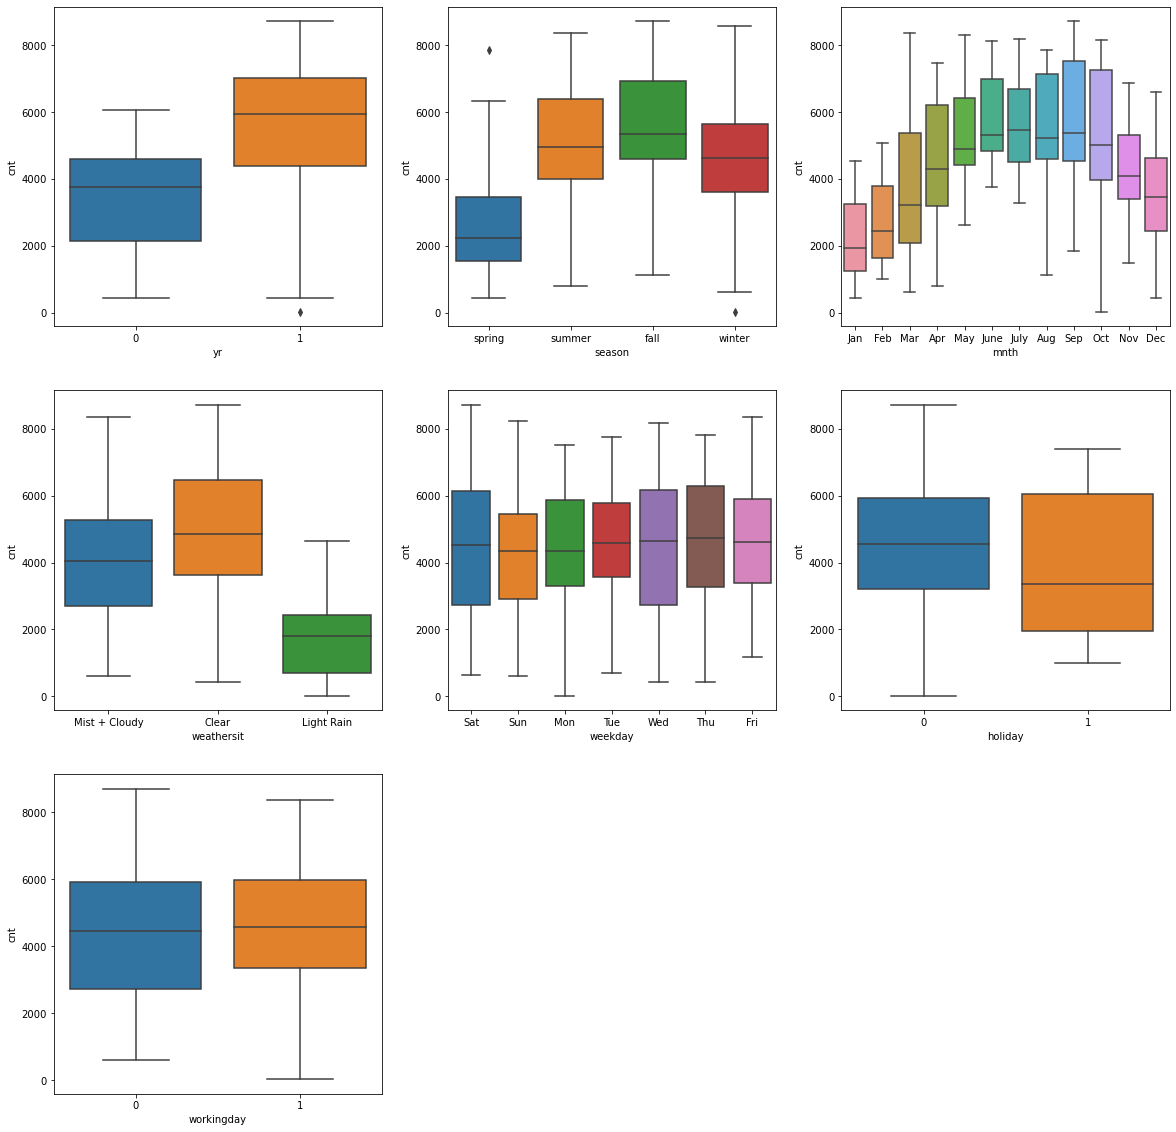

In [265]:
# Let's visualize categorical variables next
plt.figure(figsize=(20, 20))
for index, name in enumerate(['yr', 'season', 'mnth', 'weathersit', 'weekday', 'holiday', 'workingday']):
    plt.subplot(3, 3, index+1)
    sns.boxplot(x=name, y='cnt', data=bikes)
    
# Learnings:
#   - More number of bikes were rented in 2019 as compared to 2018
#   - Bike bookings are more in 'fall' season (Aug, Sept, Oct months)
#   - Bike bookings are more in 'Clear' weather
#   - Bikes are rented more on Saturdays, Wednesdays and Thursdays

In [266]:
# function to generate plots related to Categorical Variables
def cat_plot(col, x, y):
    plt.figure(figsize = (x,y))
    plt.subplot(1,2,1)
    sns.barplot(col,'cnt',data=bikes)
    plt.subplot(1,2,2)
    sns.barplot(col,'cnt',data=bikes, hue='yr',palette='Paired')
    plt.legend(labels=['2018', '2019'])
    return

# function to generate statistics related to Categorical Variables
def cat_stats(col):
    cat_df = bikes.groupby(col)['cnt'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False)
    cat_df['sum_perc']=cat_df['sum']/bikes.cnt.sum()*100
    cat_df['count_perc']=cat_df['count']/bikes.cnt.count()*100
    return round(cat_df,2)

In [267]:
# Categorical variable: mnth 
cat_stats('mnth')

,sum,mean,count,sum_perc,count_perc
mnth,,,,,
Aug,351194,5664.42,62,10.67,8.49
June,346342,5772.37,60,10.52,8.22
Sep,345991,5766.52,60,10.51,8.22
July,344948,5563.68,62,10.48,8.49
May,331686,5349.77,62,10.08,8.49
Oct,322352,5199.23,62,9.80,8.49
Apr,269094,4484.90,60,8.18,8.22
Nov,254831,4247.18,60,7.74,8.22
Mar,228920,3692.26,62,6.96,8.49


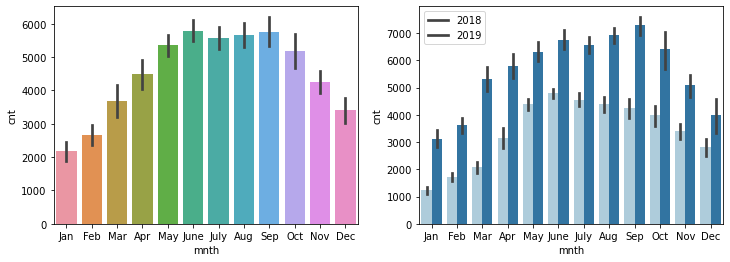

In [268]:
cat_plot('mnth',12,4)

In [78]:
# Almost 10% per month bookings are happening in the months of Aug, June, Sep, July and May, i.e. from May to Sep, that means 
# month can be good predictor for cnt

In [269]:
# Categorical variable: season 
cat_stats('season')

,sum,mean,count,sum_perc,count_perc
season,,,,,
fall,1061129,5644.30,188,32.24,25.75
summer,918589,4992.33,184,27.91,25.21
winter,841613,4728.16,178,25.57,24.38
spring,469514,2608.41,180,14.27,24.66


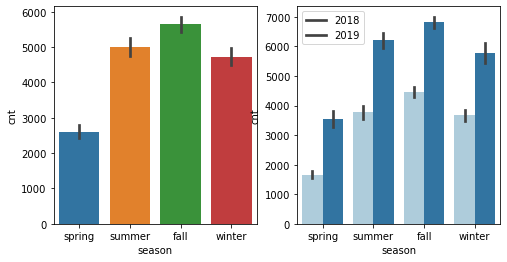

In [270]:
cat_plot('season',8,4)

In [80]:
# Almost 32% of bookings happened in the Fall season, followed by summer and winter, 
# Therefore season can also be a good predictor of cnt

In [271]:
# Categorical variable: weathersit 
cat_stats('weathersit')

,sum,mean,count,sum_perc,count_perc
weathersit,,,,,
Clear,2257952,4876.79,463,68.61,63.42
Mist + Cloudy,995024,4044.81,246,30.24,33.70
Light Rain,37869,1803.29,21,1.15,2.88


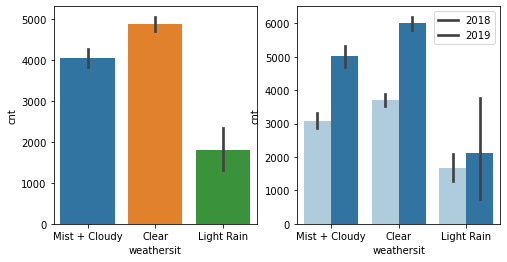

In [272]:
cat_plot('weathersit',8,4)

In [84]:
# With ~68% of bookings, Clear-Weather topped, that means there is clearly some trend in renting bikes associated with
# weather

In [273]:
# Categorical variable: weekday 
cat_stats('weekday')

,sum,mean,count,sum_perc,count_perc
weekday,,,,,
Fri,487790,4690.29,104,14.82,14.25
Thu,485395,4667.26,104,14.75,14.25
Sat,477807,4550.54,105,14.52,14.38
Wed,471214,4574.89,103,14.32,14.11
Tue,469109,4510.66,104,14.25,14.25
Mon,455503,4338.12,105,13.84,14.38
Sun,444027,4228.83,105,13.49,14.38


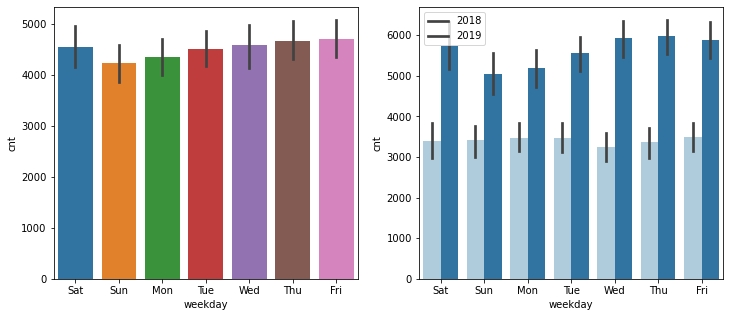

In [274]:
cat_plot('weekday',12,5)

In [96]:
# ~13-14% bookings happened everyday, thus we can not say clearly whether there is a relationship between cnt and weekday
# we may need to look deeper

In [275]:
# Categorical variable: holiday 
cat_stats('holiday')

,sum,mean,count,sum_perc,count_perc
holiday,,,,,
0,3212410,4530.9,709,97.62,97.12
1,78435,3735.0,21,2.38,2.88


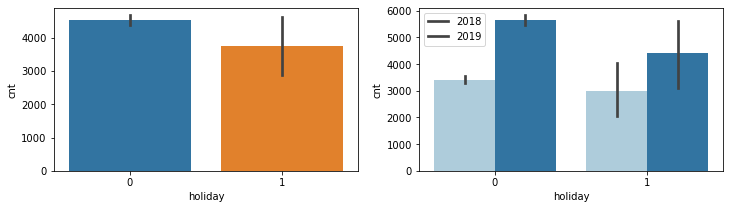

In [276]:
cat_plot('holiday',12,3)

In [105]:
# 97% of bookings happened during non-holiday days

In [277]:
# Categorical variable: workingday 
cat_stats('workingday')

,sum,mean,count,sum_perc,count_perc
workingday,,,,,
1,2290576,4590.33,499,69.6,68.36
0,1000269,4330.17,231,30.4,31.64


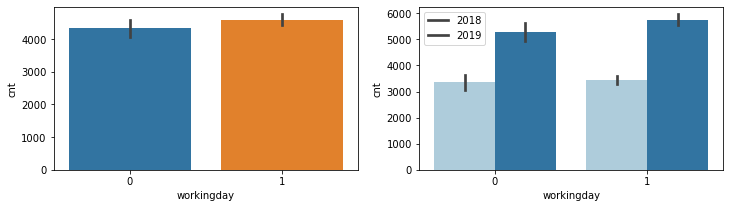

In [278]:
cat_plot('workingday',12,3)

In [108]:
# roughly 70% of the bookings happened at working days

#### * Seeing the overall relationships between cnt and other variables, It seems like MLR is possible

### Step 2 : Preparing the data for modeling

#### i. Dummy variables

In [279]:
# Creating dummy variables for the below categorical variables
categoricalCols = ['season', 'mnth', 'weathersit', 'weekday']

for col in categoricalCols:
    df = pd.get_dummies(bikes[col], drop_first=True)
    bikes = bikes.drop(col, axis=1)
    bikes = pd.concat([bikes, df], axis=1)
    
bikes.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Light Rain,Mist + Cloudy,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,1


In [280]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             730 non-null    int64  
 1   holiday        730 non-null    int64  
 2   workingday     730 non-null    int64  
 3   temp           730 non-null    float64
 4   atemp          730 non-null    float64
 5   hum            730 non-null    float64
 6   windspeed      730 non-null    float64
 7   cnt            730 non-null    int64  
 8   spring         730 non-null    uint8  
 9   summer         730 non-null    uint8  
 10  winter         730 non-null    uint8  
 11  Aug            730 non-null    uint8  
 12  Dec            730 non-null    uint8  
 13  Feb            730 non-null    uint8  
 14  Jan            730 non-null    uint8  
 15  July           730 non-null    uint8  
 16  June           730 non-null    uint8  
 17  Mar            730 non-null    uint8  
 18  May       

#### ii. Train-Test Split

In [281]:
df_train, df_test = train_test_split(bikes, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


#### iii. Rescaling

In [282]:
#min/max scaling

scaler = MinMaxScaler()

num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Light Rain,Mist + Cloudy,Mon,Sat,Sun,Thu,Tue,Wed
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,1,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,1,0,0,0,0,0,0


In [283]:
df_train[num_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Step 3: Model Building

#### RFE
We will be using RFE (Recursive Feature Selecttion) technique to shortlist our list of features

In [284]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [285]:
y_train = df_train.pop('cnt')
X_train = df_train

In [286]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)


In [287]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 7),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('July', True, 1),
 ('June', False, 14),
 ('Mar', False, 15),
 ('May', False, 6),
 ('Nov', False, 2),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Light Rain', True, 1),
 ('Mist + Cloudy', True, 1),
 ('Mon', False, 9),
 ('Sat', True, 1),
 ('Sun', False, 8),
 ('Thu', False, 11),
 ('Tue', False, 10),
 ('Wed', False, 12)]

In [288]:
#Columns where RFE support is True
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'Jan', 'July', 'Sep', 'Light Rain', 'Mist + Cloudy',
       'Sat'],
      dtype='object')

In [289]:
#Columns where RFE support is False
X_train.columns[~rfe.support_]

Index(['atemp', 'Aug', 'Dec', 'Feb', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Mon',
       'Sun', 'Thu', 'Tue', 'Wed'],
      dtype='object')

In [124]:
# NOTE: atemp has also been removed by RFE, we were anyway wanted to remove one of (temp or atemp) because while 
# doing the EDA, we observed that temp and atemp were highly correlated. So its a good thing happened for us that
# one of them got removed automatically as part of RFE

#### Building model using statsmodels, for detailed statistics

In [290]:
X_train_rfe = X_train[col]

In [291]:
X_train_rfe_sm = sm.add_constant(X_train_rfe)

In [292]:
lm = sm.OLS(y_train, X_train_rfe_sm).fit()

In [293]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          4.22e-191
Time:                        09:00:30   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2519      0.036      6.969      0.000       0.181       0.323
yr                0.2305      0.008     28.795      0.000       0.215       0.246
holiday          -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday        0.0433      0.012      3.762      0.000       0.021       0.066
temp              0.5096      0.034     14.837      0.000       0.442       0.577
hum              -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed        -0.1863      0.025     -7.310      0.000      -0.236      -0.136
spring           -0.0509      0.021     -2.464      0.014      -0.091      -0.010
summer            0.0508      0.015      3.423      0.001       0.022       0.080
winter            0.0933      0.017      5.403      0.000       0.059       0.127
Jan              -0.0345      0.017     -1.989      0.047      -0.069      -0.000
July             -0.0529      0.018     -2.931      0.004      -0.088      -0.017
Sep               0.0814      0.016      4.945      0.000       0.049       0.114
Light Rain       -0.2475      0.026     -9.507      0.000      -0.299      -0.196
Mist + Cloudy    -0.0563      0.010     -5.439      0.000      -0.077      -0.036
Sat               0.0536      0.014      3.694      0.000       0.025       0.082
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

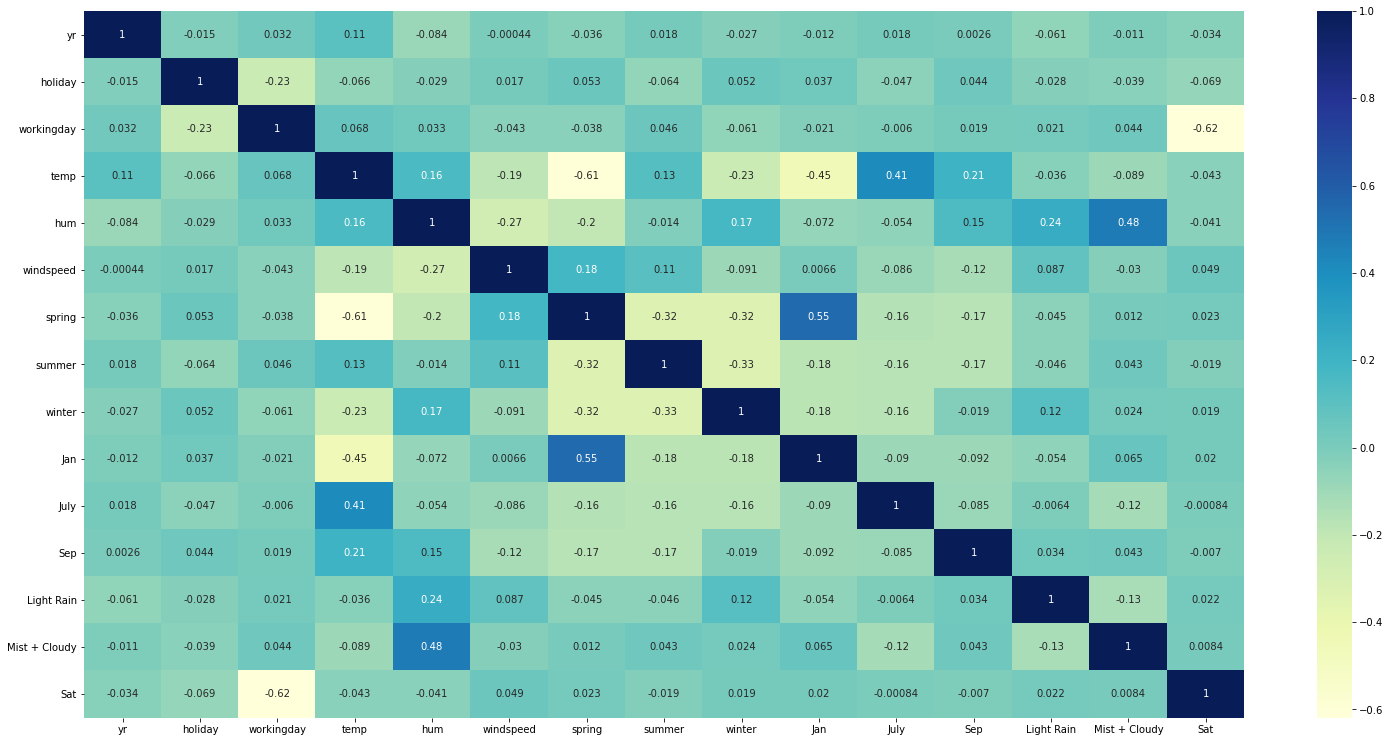

In [294]:
# p-values for all of our predictor variables is quite low, 
# Therefore Let's look at correlation among all the predictor variables once again via heatmap, 
# to look for any multi-collinearity, and we will also check their VIFs (will remove the ones with high VIFs)
plt.figure(figsize=(26,13))
sns.heatmap(X_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [295]:
# function to show the VIF scores of predictor features
def showVIFs(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif

In [296]:
showVIFs(X_train_rfe)

,Features,VIF
4,hum,29.37
3,temp,17.78
2,workingday,5.31
5,windspeed,4.73
6,spring,4.53
8,winter,3.46
7,summer,2.85
13,Mist + Cloudy,2.29
0,yr,2.09
14,Sat,1.98


In [297]:
# As 'hum' has high VIF values among all the variables, let's remove it and try building the model again
X = X_train_rfe.drop('hum', axis = 1)

In [298]:
X_sm = sm.add_constant(X)

In [299]:
lm = sm.OLS(y_train, X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.60e-188
Time:                        09:01:14   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1737      0.031      5.520      0.000       0.112       0.235
yr                0.2345      0.008     29.009      0.000       0.219       0.250
holiday          -0.0558      0.027     -2.042      0.042      -0.109      -0.002
workingday        0.0464      0.012      3.966      0.000       0.023       0.069
temp              0.4722      0.034     14.005      0.000       0.406       0.538
windspeed        -0.1563      0.025     -6.286      0.000      -0.205      -0.107
spring           -0.0599      0.021     -2.867      0.004      -0.101      -0.019
summer            0.0445      0.015      2.967      0.003       0.015       0.074
winter            0.0784      0.017      4.562      0.000       0.045       0.112
Jan              -0.0392      0.018     -2.227      0.026      -0.074      -0.005
July             -0.0479      0.018     -2.614      0.009      -0.084      -0.012
Sep               0.0755      0.017      4.527      0.000       0.043       0.108
Light Rain       -0.2908      0.024    -11.977      0.000      -0.339      -0.243
Mist + Cloudy    -0.0813      0.009     -9.437      0.000      -0.098      -0.064
Sat               0.0583      0.015      3.968      0.000       0.029       0.087
==============================================================================
Omnibus:                       67.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.565
Skew:                          -0.692   Prob(JB):                     1.84e-36
Kurtosis:                       5.415   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
showVIFs(X)

,Features,VIF
3,temp,7.07
2,workingday,5.24
4,windspeed,4.68
5,spring,3.07
6,summer,2.34
0,yr,2.08
7,winter,1.98
13,Sat,1.97
8,Jan,1.62
9,July,1.59


In [301]:
# Although 'temp' has the highest VIF among all, but we will not drop it, since, we saw in our EDA that temp is highly 
# correlated with 'cnt', Therefore, let's remove the next variable in the list having second highest VIF score. 
# i.e. 'workingday' (which also wasn't much correlated with cnt)
X = X.drop('workingday', axis = 1)

In [302]:
X_sm = sm.add_constant(X)

In [303]:
lm = sm.OLS(y_train, X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.1
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.48e-186
Time:                        09:01:47   Log-Likelihood:                 502.77
No. Observations:                 510   AIC:                            -977.5
Df Residuals:                     496   BIC:                            -918.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2120      0.030      6.978      0.000       0.152       0.272
yr                0.2347      0.008     28.620      0.000       0.219       0.251
holiday          -0.0934      0.026     -3.589      0.000      -0.144      -0.042
temp              0.4734      0.034     13.837      0.000       0.406       0.541
windspeed        -0.1570      0.025     -6.226      0.000      -0.207      -0.107
spring           -0.0615      0.021     -2.902      0.004      -0.103      -0.020
summer            0.0437      0.015      2.871      0.004       0.014       0.074
winter            0.0755      0.017      4.334      0.000       0.041       0.110
Jan              -0.0386      0.018     -2.159      0.031      -0.074      -0.003
July             -0.0508      0.019     -2.735      0.006      -0.087      -0.014
Sep               0.0762      0.017      4.504      0.000       0.043       0.109
Light Rain       -0.2859      0.025    -11.619      0.000      -0.334      -0.238
Mist + Cloudy    -0.0794      0.009     -9.097      0.000      -0.097      -0.062
Sat               0.0201      0.011      1.787      0.075      -0.002       0.042
==============================================================================
Omnibus:                       66.209   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.692
Skew:                          -0.716   Prob(JB):                     1.03e-31
Kurtosis:                       5.160   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
showVIFs(X)

,Features,VIF
2,temp,5.16
3,windspeed,4.64
4,spring,2.76
5,summer,2.24
0,yr,2.07
6,winter,1.80
7,Jan,1.61
8,July,1.59
11,Mist + Cloudy,1.56
9,Sep,1.34


In [305]:
# Although 'temp' still has the highest VIF among all, but we will not drop it, since, we saw in our EDA that temp is highly 
# correlated with 'cnt', Therefore, let's remove the next variable in the list having second highest VIF score. 
# i.e. 'windspeed' (which also wasn't much correlated with cnt)
X = X.drop('windspeed', axis = 1)


In [306]:
X_sm = sm.add_constant(X)

In [307]:
lm = sm.OLS(y_train, X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     195.5
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.04e-179
Time:                        09:03:52   Log-Likelihood:                 483.58
No. Observations:                 510   AIC:                            -941.2
Df Residuals:                     497   BIC:                            -886.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1552      0.030      5.162      0.000       0.096       0.214
yr                0.2334      0.009     27.442      0.000       0.217       0.250
holiday          -0.0971      0.027     -3.600      0.000      -0.150      -0.044
temp              0.4927      0.035     13.941      0.000       0.423       0.562
spring           -0.0734      0.022     -3.353      0.001      -0.116      -0.030
summer            0.0346      0.016      2.199      0.028       0.004       0.065
winter            0.0790      0.018      4.374      0.000       0.044       0.114
Jan              -0.0241      0.018     -1.313      0.190      -0.060       0.012
July             -0.0517      0.019     -2.682      0.008      -0.089      -0.014
Sep               0.0809      0.018      4.616      0.000       0.046       0.115
Light Rain       -0.3007      0.025    -11.837      0.000      -0.351      -0.251
Mist + Cloudy    -0.0779      0.009     -8.612      0.000      -0.096      -0.060
Sat               0.0168      0.012      1.442      0.150      -0.006       0.040
==============================================================================
Omnibus:                       74.706   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.798
Skew:                          -0.759   Prob(JB):                     5.50e-40
Kurtosis:                       5.491   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [308]:
showVIFs(X)

,Features,VIF
2,temp,4.34
0,yr,2.07
3,spring,2.02
4,summer,1.95
6,Jan,1.60
5,winter,1.59
7,July,1.59
10,Mist + Cloudy,1.56
8,Sep,1.34
11,Sat,1.19


In [310]:
# Apparently removing 'windspeed' also brought down the VIF of 'temp', 
# But now 'Jan' & 'Sat' have increased beyond 0.05, Thus we will also remove these 1-by-1, starting with 'Jan'
# first, since it has the highest p-value
X = X.drop('Jan', axis = 1)

In [311]:
X_sm = sm.add_constant(X)

In [312]:
lm = sm.OLS(y_train, X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     212.8
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          3.21e-180
Time:                        09:07:01   Log-Likelihood:                 482.70
No. Observations:                 510   AIC:                            -941.4
Df Residuals:                     498   BIC:                            -890.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1466      0.029      4.992      0.000       0.089       0.204
yr                0.2329      0.009     27.392      0.000       0.216       0.250
holiday          -0.0975      0.027     -3.611      0.000      -0.150      -0.044
temp              0.5042      0.034     14.719      0.000       0.437       0.572
spring           -0.0766      0.022     -3.517      0.000      -0.119      -0.034
summer            0.0368      0.016      2.355      0.019       0.006       0.068
winter            0.0828      0.018      4.642      0.000       0.048       0.118
July             -0.0527      0.019     -2.738      0.006      -0.091      -0.015
Sep               0.0811      0.018      4.621      0.000       0.047       0.116
Light Rain       -0.2995      0.025    -11.789      0.000      -0.349      -0.250
Mist + Cloudy    -0.0785      0.009     -8.685      0.000      -0.096      -0.061
Sat               0.0168      0.012      1.436      0.152      -0.006       0.040
==============================================================================
Omnibus:                       73.091   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.335
Skew:                          -0.744   Prob(JB):                     5.12e-39
Kurtosis:                       5.466   Cond. No.                         16.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [313]:
showVIFs(X)

,Features,VIF
2,temp,4.27
0,yr,2.07
4,summer,1.94
5,winter,1.59
6,July,1.58
9,Mist + Cloudy,1.55
3,spring,1.43
7,Sep,1.34
10,Sat,1.19
8,Light Rain,1.07


In [314]:
# Let's remove 'Sat' now, since it still has high p-value
X = X.drop('Sat', axis = 1)

In [315]:
X_sm = sm.add_constant(X)

In [316]:
lm = sm.OLS(y_train, X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          5.71e-181
Time:                        09:08:16   Log-Likelihood:                 481.64
No. Observations:                 510   AIC:                            -941.3
Df Residuals:                     499   BIC:                            -894.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1501      0.029      5.124      0.000       0.093       0.208
yr                0.2326      0.009     27.333      0.000       0.216       0.249
holiday          -0.1003      0.027     -3.721      0.000      -0.153      -0.047
temp              0.5029      0.034     14.670      0.000       0.436       0.570
spring           -0.0766      0.022     -3.514      0.000      -0.119      -0.034
summer            0.0367      0.016      2.342      0.020       0.006       0.067
winter            0.0829      0.018      4.642      0.000       0.048       0.118
July             -0.0523      0.019     -2.715      0.007      -0.090      -0.014
Sep               0.0812      0.018      4.623      0.000       0.047       0.116
Light Rain       -0.2989      0.025    -11.756      0.000      -0.349      -0.249
Mist + Cloudy    -0.0785      0.009     -8.669      0.000      -0.096      -0.061
==============================================================================
Omnibus:                       66.927   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.674
Skew:                          -0.678   Prob(JB):                     1.74e-36
Kurtosis:                       5.431   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
showVIFs(X)

,Features,VIF
2,temp,4.22
0,yr,2.06
4,summer,1.94
6,July,1.58
5,winter,1.57
9,Mist + Cloudy,1.55
3,spring,1.40
7,Sep,1.34
8,Light Rain,1.07
1,holiday,1.04


In [319]:
# Since all the VIFs are less than 5, and p-values for all the variables are less then 0.05, Thus, we can stop at this
# point, and start evaluating our Final model

#### Residual Analysis

In [320]:
y_train_pred = lm.predict(X_sm)

<AxesSubplot:ylabel='Density'>

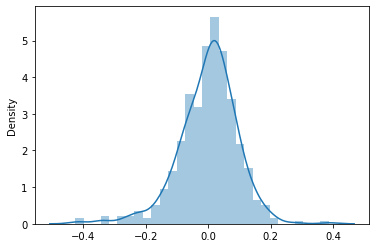

In [321]:
res = y_train - y_train_pred
sns.distplot(res)

In [322]:
# Residual analysis looks good, as it's centered around 0

### Step 4: Making predictions and Evaluation on the test set

In [323]:
# Transform the test set

In [324]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Light Rain,Mist + Cloudy,Mon,Sat,Sun,Thu,Tue,Wed
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,1,1,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,0,0,0,0,0,1
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,1,0,0,1,0,0,0,1,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,1
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,0,0,0,0,1,0,0


In [325]:
df_test[num_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.532847,0.638221,0.313293,0.522154
std,0.233187,0.217401,0.148694,0.159584,0.219163
min,0.046591,0.025950,0.261915,-0.042808,0.048205
25%,0.355429,0.344870,0.529197,0.198843,0.378595
50%,0.558172,0.544652,0.625590,0.300126,0.524678
75%,0.755981,0.713308,0.743798,0.402718,0.677750
max,0.984424,0.980934,1.002146,0.807474,0.963300


In [326]:
y_test = df_test.pop('cnt')
X_test = df_test

In [327]:
# drop the variables which are not part of our final model
X_test = X_test[X.columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 184 to 653
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             220 non-null    int64  
 1   holiday        220 non-null    int64  
 2   temp           220 non-null    float64
 3   spring         220 non-null    uint8  
 4   summer         220 non-null    uint8  
 5   winter         220 non-null    uint8  
 6   July           220 non-null    uint8  
 7   Sep            220 non-null    uint8  
 8   Light Rain     220 non-null    uint8  
 9   Mist + Cloudy  220 non-null    uint8  
dtypes: float64(1), int64(2), uint8(7)
memory usage: 8.4 KB


In [328]:
# add constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,temp,spring,summer,winter,July,Sep,Light Rain,Mist + Cloudy
184,1.0,0,1,0.831783,0,0,0,1,0,0,1
535,1.0,1,0,0.901354,0,1,0,0,0,0,0
299,1.0,0,0,0.511964,0,0,1,0,0,0,1
221,1.0,0,0,0.881625,0,0,0,0,0,0,0
152,1.0,0,0,0.817246,0,1,0,0,0,0,0


In [329]:
y_test_pred = lm.predict(X_test_sm)

Text(0, 0.5, 'y_test_pred')

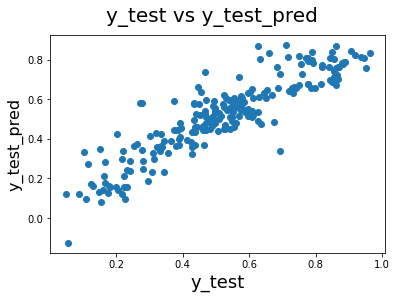

In [331]:
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)        # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)  

In [332]:
#evaluate

test_r2_score = 100*r2_score(y_true=y_test, y_pred=y_test_pred)
train_r2_score = 100*r2_score(y_true=y_train, y_pred=y_train_pred)
diffr = train_r2_score - test_r2_score

print('Test R2 Score: ', round(test_r2_score, 2))
print('Train R2 Score: ', round(train_r2_score, 2))
print('Differnce between Train and Test R2 Scores: ', round(diffr, 2), '%')

# Difference between the R2Score for test and train is less then 5%, hence this is a stable model

Test R2 Score:  80.93
Train R2 Score:  82.38
Differnce between Train and Test R2 Scores:  1.46 %


### Step 5: Interpreting the model

In [341]:
round(lm.params,4).sort_values(ascending=False)

temp             0.5029
yr               0.2326
const            0.1501
winter           0.0829
Sep              0.0812
summer           0.0367
July            -0.0523
spring          -0.0766
Mist + Cloudy   -0.0785
holiday         -0.1003
Light Rain      -0.2989
dtype: float64

### We can see that the equation of our best fitted line is:
##### cnt = (0.5029 x temp) + (0.2326 × yr)  + (0.0829 x winter) 
#####        + (0.0812 x Sep) + (0.0367 x summer)  - (0.0523 x July)
#####        - (0.0766 x spring) - (0.0785 x Mist_Cloudy) - (0.1003 x holiday)
#####        - (0.2989 x Light_Rain) + 0.1501

## Conclusion

The top 5 variables contributing significantly towards explaining the demand for shared bikes are as follows (not considering the  constant):

1. temp   : 0.5029
2. yr     : 0.2326
3. winter : 0.0829
4. Sep    : 0.0812
5. summer : 0.0367